<h1>Analyse cryptos Futures sur Bitget</h1>
SEG

In [3]:
import sys
sys.path.append('../')
from utilities.data_manager import ExchangeDataManager
import pandas as pd

<h2>Liste de toutes les paires Futures sur Bitget</h2>

In [4]:
import requests
import re

url = "https://api.bitget.com/api/v2/mix/market/tickers?productType=USDT-FUTURES"

response = requests.get(url)
data = response.json()

if response.status_code == 200:
    # Extraction des noms des cryptomonnaies au format "BTC/USDT:USDT"
    futures_cryptos = [market['symbol'] for market in data['data']]
    formatted_cryptos = [f"{crypto[:-4]}/USDT:USDT" for crypto in futures_cryptos]
    print(f"Cryptomonnaies disponibles en futures sur Bitget: {len(formatted_cryptos)}")
    print(formatted_cryptos)
else:
    print(f"Erreur lors de la requête : {response.status_code}")

Cryptomonnaies disponibles en futures sur Bitget: 193
['BTC/USDT:USDT', 'ETH/USDT:USDT', 'XRP/USDT:USDT', 'EOS/USDT:USDT', 'BCH/USDT:USDT', 'LTC/USDT:USDT', 'ADA/USDT:USDT', 'ETC/USDT:USDT', 'LINK/USDT:USDT', 'TRX/USDT:USDT', 'DOT/USDT:USDT', 'DOGE/USDT:USDT', 'SOL/USDT:USDT', 'MATIC/USDT:USDT', 'BNB/USDT:USDT', 'UNI/USDT:USDT', 'ICP/USDT:USDT', 'AAVE/USDT:USDT', 'FIL/USDT:USDT', 'XLM/USDT:USDT', 'ATOM/USDT:USDT', 'XTZ/USDT:USDT', 'SUSHI/USDT:USDT', 'AXS/USDT:USDT', 'THETA/USDT:USDT', 'AVAX/USDT:USDT', 'DASH/USDT:USDT', 'SHIB/USDT:USDT', 'MANA/USDT:USDT', 'GALA/USDT:USDT', 'SAND/USDT:USDT', 'DYDX/USDT:USDT', 'CRV/USDT:USDT', 'NEAR/USDT:USDT', 'EGLD/USDT:USDT', 'KSM/USDT:USDT', 'AR/USDT:USDT', 'FTM/USDT:USDT', 'PEOPLE/USDT:USDT', 'LRC/USDT:USDT', 'NEO/USDT:USDT', 'WAVES/USDT:USDT', 'ALGO/USDT:USDT', 'IOTA/USDT:USDT', 'ENJ/USDT:USDT', 'GMT/USDT:USDT', 'ZIL/USDT:USDT', 'IOST/USDT:USDT', 'APE/USDT:USDT', 'RUNE/USDT:USDT', 'KNC/USDT:USDT', 'APT/USDT:USDT', 'CHZ/USDT:USDT', 'XMR/USDT:USDT', 

<h2>Téléchargement de toutes les paires sur Bitget</h2>

In [ ]:
exchange_name = "bitget"
intervals = ["1h"]

exchange = ExchangeDataManager(exchange_name=exchange_name, path_download="../database/exchanges")
await exchange.download_data(coins=formatted_cryptos, intervals=intervals,)

Chargement des données

In [5]:
pair_list = formatted_cryptos
exchange_name = "bitget"
tf = '1h'
oldest_pair = "BTC/USDT:USDT"
start_date = "2021-10"

exchange = ExchangeDataManager(
    exchange_name=exchange_name, 
    path_download="../database/exchanges"
)

df_list = {}
for pair in pair_list:
    df = exchange.load_data(pair, tf)
    # df_list[pair] = df.loc[:]
    df_list[pair] = df.loc[start_date:]

print("Data load 100%")
# df_list[oldest_pair]

Data load 100%


<h2>Matrice de correlation</h2>

Nombre de crypto: 26
Corrélation moyenne entre toutes les cryptos : 0.8531659431082791
Cryptos avec des corrélations moyennes < à 0.75:
TRX      0.370180
MATIC    0.747605
dtype: float64
Cryptos avec des corrélations moyennes > à 0.89:
UNI      0.891601
EOS      0.893391
FIL      0.894773
SUSHI    0.895013
DOGE     0.896988
XLM      0.904361
AXS      0.904969
ADA      0.906112
ICP      0.906127
AAVE     0.907703
DOT      0.908796
THETA    0.911085
dtype: float64


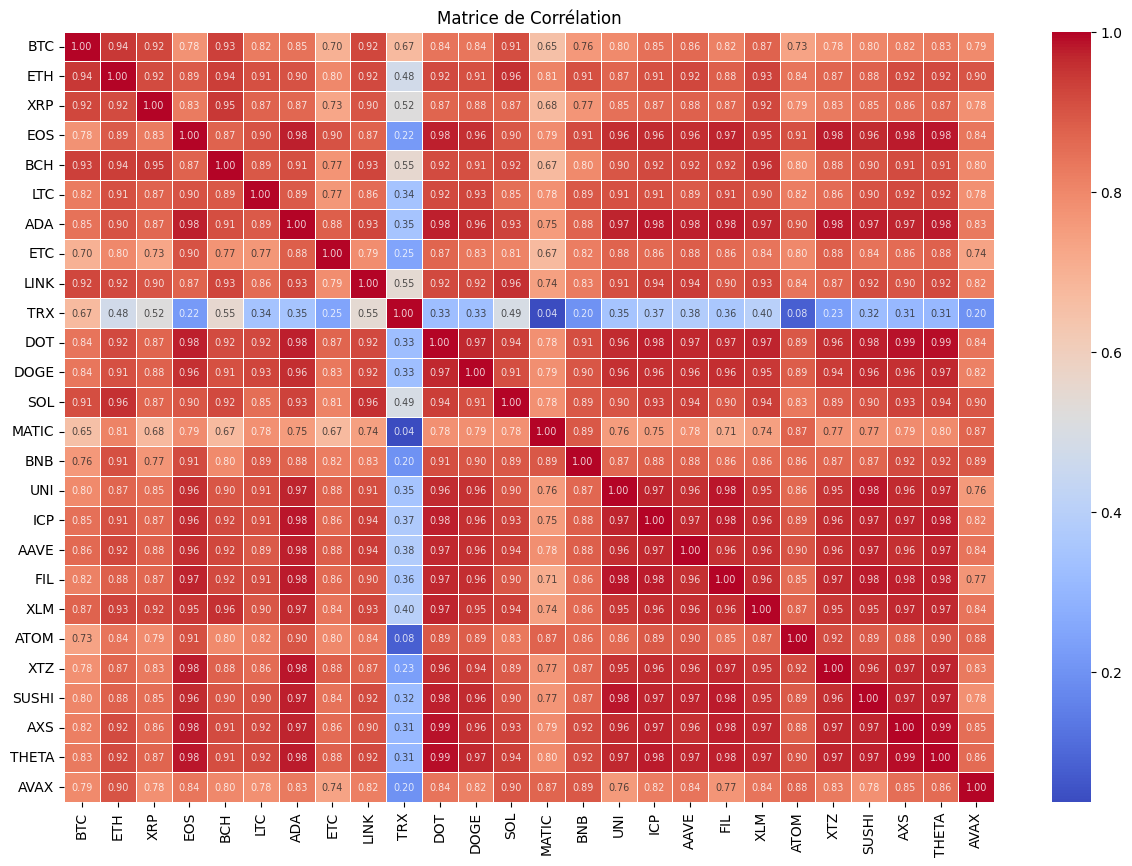

In [20]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

close_prices_list = []
volatility_dict = {}

for crypto, df in df_list.items():
    crypto_name = crypto.split('/')[0]
    
    if (df.index <= start_date).any():
        close_prices_list.append(df['close'].rename(crypto_name))
        returns = df['close'].pct_change().dropna()
        volatility = returns.std()
        volatility_dict[crypto_name] = volatility
        
close_prices = pd.concat(close_prices_list, axis=1)
print(f"Nombre de crypto: {len(close_prices_list)}")

# Calcul de la matrice de corrélation
correlation_matrix = close_prices.corr()

average_correlation = correlation_matrix.mean().mean()
print(f"Corrélation moyenne entre toutes les cryptos : {average_correlation}")
sorted_correlation = correlation_matrix.mean().sort_values()
seuil_faible, seuil_forte = 0.75, 0.89
cryptos_faibles_correlations = sorted_correlation[sorted_correlation < seuil_faible]
cryptos_fortes_correlations = sorted_correlation[sorted_correlation > seuil_forte]

print(f"Cryptos avec des corrélations moyennes < à {seuil_faible}:")
print(correlation_matrix[cryptos_faibles_correlations.index].mean())
print(f"Cryptos avec des corrélations moyennes > à {seuil_forte}:")
print(correlation_matrix[cryptos_fortes_correlations.index].mean())

# Affichez la matrice de corrélation avec seaborn
plt.figure(figsize=(15, 10))
# mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidth=.5, 
            annot_kws={'size': 'x-small', 'alpha': 0.8})
plt.title('Matrice de Corrélation')
plt.show()

In [7]:
sorted_correlation['TRX']  # Pour analyse unique

0.3701799884432245

<h2>Volatilité par crypto</h2>

Nombre de crypto: 26


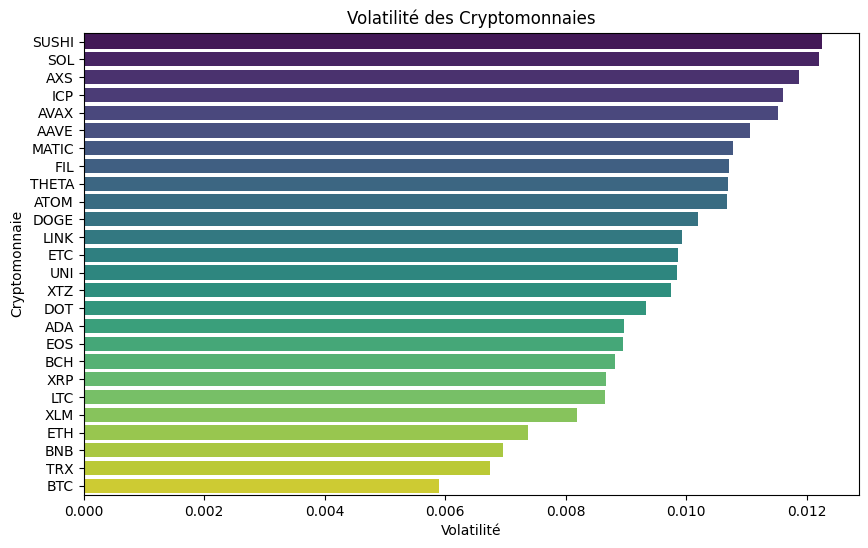

In [8]:
volatility_df = pd.DataFrame(list(volatility_dict.items()), columns=['Crypto', 'Volatility'])
sorted_volatility_df = volatility_df.sort_values(by='Volatility', ascending=False)

print(f"Nombre de crypto: {len(volatility_df)}")

# Visualisation de l'écart de volatilité
plt.figure(figsize=(10, 6))
sns.barplot(x='Volatility', y='Crypto', data=sorted_volatility_df, palette='viridis', hue='Crypto', dodge=False)
plt.title('Volatilité des Cryptomonnaies')
plt.xlabel('Volatilité')
plt.ylabel('Cryptomonnaie')
plt.show()

# # Afficher les cryptos les plus volatiles
# print("Cryptos avec la plus grande volatilité :")
# print(sorted_volatility_df)

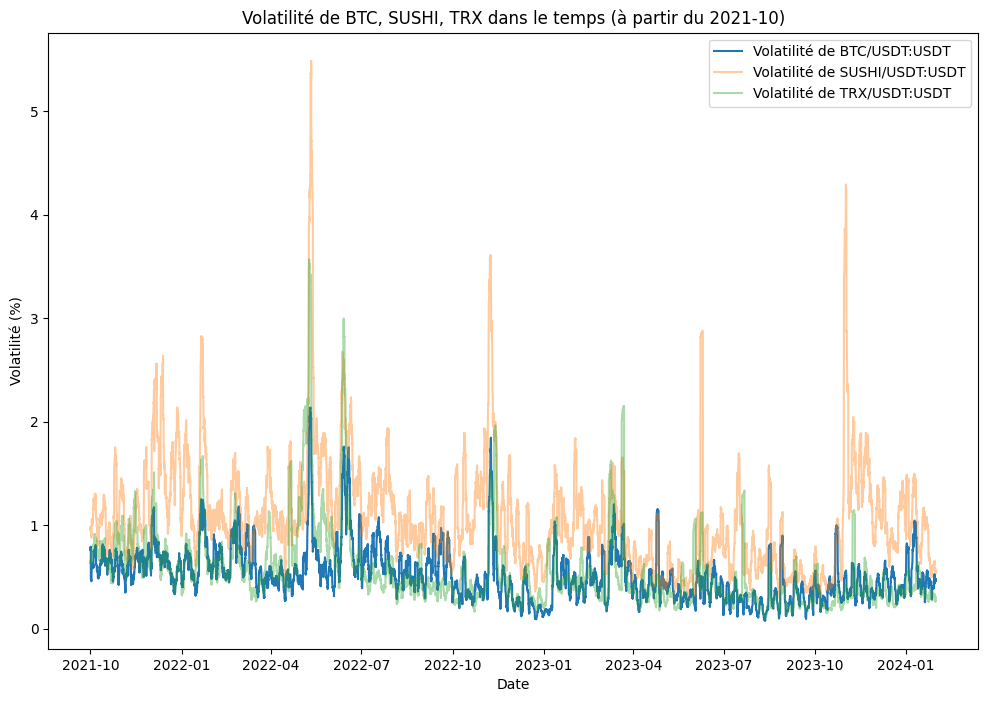

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Cryptos à comparer
cryptos_selected = ['BTC/USDT:USDT', 'SUSHI/USDT:USDT', 'TRX/USDT:USDT']
volatility_over_time = {crypto: [] for crypto in cryptos_selected}

# Taille de la fenêtre glissante pour le calcul de la volatilité
window_size = 60

plt.figure(figsize=(12, 8))

for crypto in cryptos_selected:
    df_selected = df_list[crypto]
    df_selected = df_selected[df_selected.index >= start_date]

    close_prices = df_selected['close'].values
    returns = np.diff(close_prices) / close_prices[:-1]
    volatilities = np.std(np.lib.stride_tricks.sliding_window_view(returns, window_size), axis=1) * 100
    volatility_over_time[crypto] = volatilities.tolist()

    min_length = min(len(volatility_over_time[crypto]), len(df_selected))
    common_index = df_selected.index[:min_length]

    alpha_value = 1 if 'BTC' in crypto else 0.4
    plt.plot(common_index, volatility_over_time[crypto][:min_length], label=f'Volatilité de {crypto}', alpha=alpha_value)

plt.xlabel('Date')
plt.ylabel('Volatilité (%)')
plt.title(f'Volatilité de {", ".join(c.split("/")[0] for c in cryptos_selected)} dans le temps (à partir du {start_date})')
plt.legend()
plt.show()

Comparaison

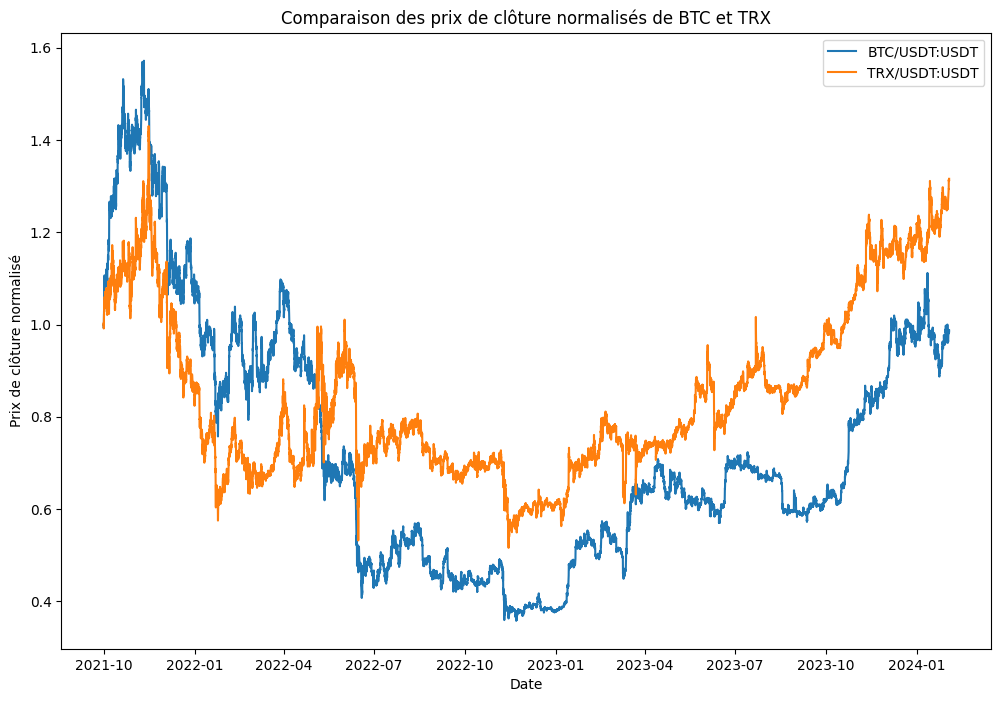

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Cryptos à comparer
cryptos_selected = ['BTC/USDT:USDT', 'TRX/USDT:USDT']
normalized_close_prices_list = {}

for crypto in cryptos_selected:
    df_selected = df_list[crypto]
    close_prices = df_selected['close']
    normalized_close_prices = close_prices / close_prices.iloc[0]
    normalized_close_prices_list[crypto] = normalized_close_prices

plt.figure(figsize=(12, 8))

for crypto, normalized_close_prices in normalized_close_prices_list.items():
    plt.plot(df_list[crypto].index, normalized_close_prices, label=crypto)

plt.xlabel('Date')
plt.ylabel('Prix de clôture normalisé')
plt.title(f'Comparaison des prix de clôture normalisés de {cryptos_selected[0].split('/')[0]} et {cryptos_selected[1].split('/')[0]}')
plt.legend()
plt.show()